# 2.7

In [123]:
import ugradio
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import glob
import astropy
import time
import astropy.units as u

In [38]:
def PS(x, divisor):
    """Takes in a complex array and outputs a plot of frequency versus power spectrum."""

    Vsamp = 62.5/divisor
    N = 16000
    
    a = x[:len(x)/2]
    b = x[len(x)/2:]
    c = a + b * 1j

    time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)
    
    f,fx = ugradio.dft.dft(c[:N],t=time, vsamp=Vsamp)
    P = np.abs(fx)**2
    plt.plot(f,P)
    plt.xlabel("Frequency")
    plt.ylabel("Power [volt-second^2]")
    plt.show()

## Average

### Changing First LO

LO for upper baseband: 1231 MHz

LO for lower baseband: 1229 MHz

Power of LO: 13 dBm

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000)

np.save('upper_block_n', x)

Took data 10 times resulting in 10,000 total blocks. Repeated for lower.

In [2]:
def avg_ps(data, n=1000):
    """Takes in a dualmode dataset of n blocks -- 16000 samples each -- and returns a power spectrum averaged over all blocks.
    
    Parameters
    ----------
    data : data taken from pico sampler, loaded as an array
    n : number of blocks of data taken

    Returns
    -------
    avg_power : average power spectrum of n blocks of complex data"""
    
    real = data[:len(data)/2]
    imag = data[len(data)/2:len(data)]
    complex_data = real + (imag * 1j)
   
    power_blocks = [] # total len = n, item len = 16000

    for i in range(n):
        x = complex_data[i * 16000 : 16000 * (i + 1)]
        voltage = np.fft.fft(x)
        power = np.abs(voltage)**2
        power_blocks.append(power)
         
    avg_power = sum(power_blocks) / len(power_blocks)
    return(avg_power)

In [4]:
upper = [avg_ps(np.load(f), 1000) for f in glob.glob('upper_block_*.npy')]

<IPython.core.display.Javascript object>


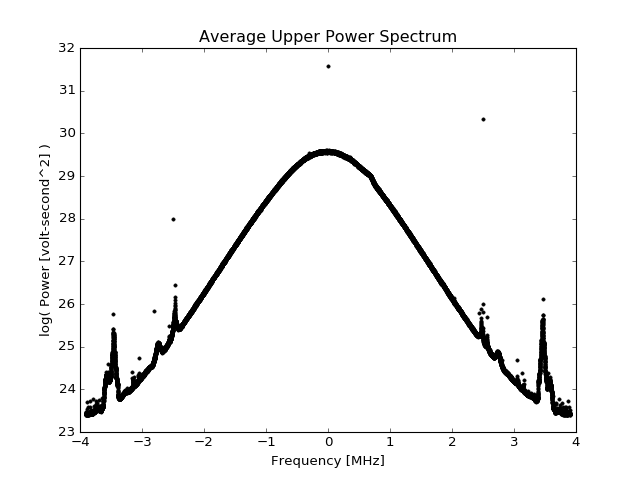

In [5]:
avg_upper = sum(upper) / len(upper)
frequency = np.fft.fftfreq(len(avg_upper), 1/(62.5/8))

plt.plot(frequency, np.log(avg_upper), 'k.')
plt.title('Average Upper Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

In [7]:
lower = [avg_ps(np.load(f),1000) for f in glob.glob('lower_block_*.npy')]

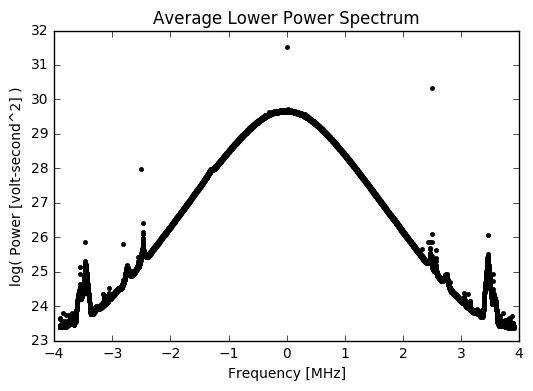

In [8]:
avg_lower = sum(lower) / len(lower)
frequency = np.fft.fftfreq(len(avg_lower), 1/(62.5/8))

plt.plot(frequency, np.log(avg_lower), 'k.')
plt.title('Average Lower Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

## Line Shape

In [9]:
s_on = avg_upper
s_off = avg_lower

s_line = s_on/s_off

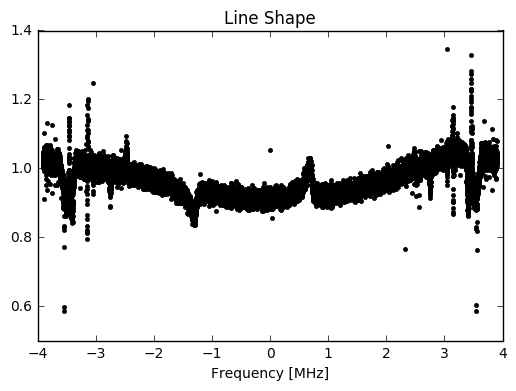

In [66]:
frequency = np.fft.fftfreq(len(s_line), 1/(62.5/8))
plt.plot(frequency, s_line, 'k.')
plt.title('Line Shape')
plt.xlabel('Frequency [MHz]')
plt.show()

## Line Intensity

In [10]:
T_cold = 3 # K
T_cal = 300 # K

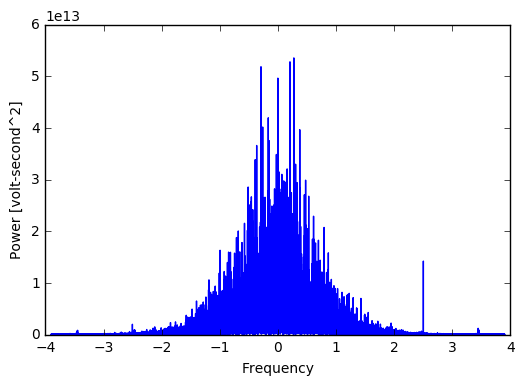

In [48]:
cold = np.loadtxt('sCold-2-24-19.txt')
PS(cold, 8)
plt.title('Sky Power Spectrum')

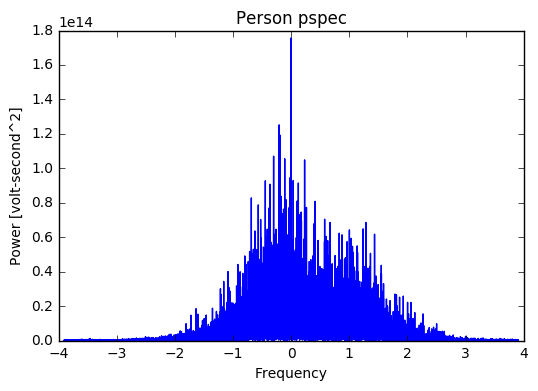

In [45]:
cal = np.loadtxt('sPerson-2-24-19.txt')
PS(cal, 8)
plt.title('People Power Spectrum')

In [11]:
Vsamp = 62.5/8
N = 16000
time = np.linspace(-N/(2*Vsamp),(N/2-1)/Vsamp,N)

cold = np.loadtxt('sCold-2-24-19.txt')
a_cold = cold[:len(cold)/2]
b_cold = cold[len(cold)/2:]
c_cold = a_cold + b_cold * 1j
f,fx = ugradio.dft.dft(c_cold[:N],t=time, vsamp=Vsamp)
P_cold = np.abs(fx)**2

cal = np.loadtxt('sPerson-2-24-19.txt')
a_cal = cal[:len(cal)/2]
b_cal = cal[len(cal)/2:]
c_cal = a_cal + b_cal * 1j
f,fx = ugradio.dft.dft(c_cal[:N],t=time, vsamp=Vsamp)
P_cal = np.abs(fx)**2

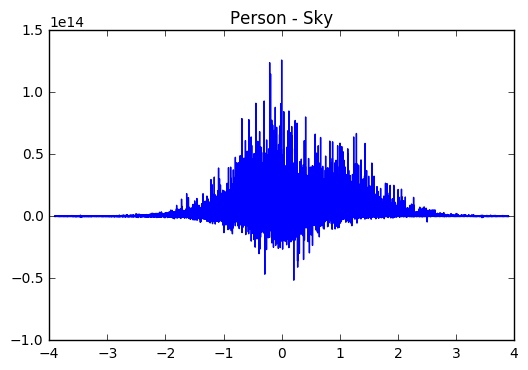

In [39]:
plt.plot(f, P_cal-P_cold)
plt.title('Person - Sky')
plt.show()

In [12]:
# obtain gain

G = (T_cal - T_cold)/(np.sum(P_cal - P_cold)) * np.sum(P_cold)
print(G)

126.34495924


In [13]:
T_line = s_line * G

## Plot Intensity vs. Frequency -- and Velocity

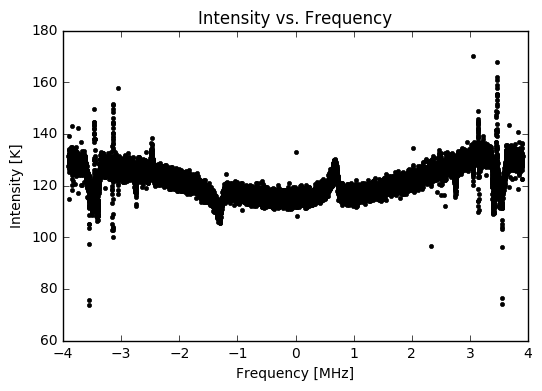

In [68]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8))
plt.plot(frequency, T_line, 'k.')
plt.title('Intensity vs. Frequency')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()

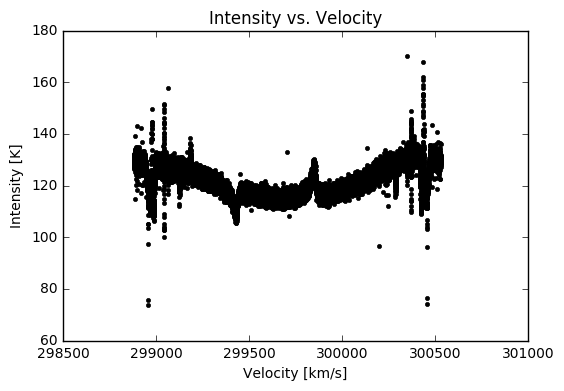

In [37]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8)) + 1420

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * frequency/f_0

plt.plot(velocity, T_line, 'k.')
plt.title('Intensity vs. Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.locator_params(axis='x', nbins=8)
plt.show()

## Doppler Correction

ugradio.doppler.get_projected_velocity(ra, dec, jd, obs_lat=37.873199, obs_lon=-122.257063, obs_alt=120.0, epoch=2451545.0)

get_projected_velocity(ra, dec, jd, obs_lat=nch.lat, obs_lon=nch.lon, 
        obs_alt=nch.alt, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=nch.lat
    obs_lon : float degrees, longitude of observatory, default=nch.lon
    obs_alt : float meters, altitude of observatory, default=nch.alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000

    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''

In [43]:
# data taken changing first LO

lat = 37.873199 # for Campbell Hall

jd = 2458539.451389 # 22:50 UTC (14:50 PST), 2/24/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 
print(v)

[-16861.65812534]


data taken changing second LO

lat = 37.873199 # for Campbell Hall

jd = ugradio.timing.julian_date() # 20:42 UTC (12:42 PST), 2/27/2019
lst = ugradio.timing.lst()

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 
print(v)

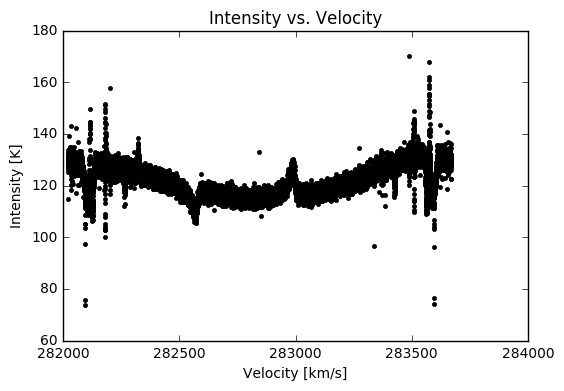

In [64]:
frequency = np.fft.fftfreq(len(T_line), 1/(62.5/8)) + 1420

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * frequency/f_0

v = -16861.65812534

plt.plot((velocity + v), T_line, 'k.')
plt.title('Intensity vs. Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.locator_params(axis='x', nbins=8)
plt.show()

# 2.8

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie', x)

In [39]:
lat = 37.873199 # for Campbell Hall

jd = 2458546.61111 # 18:40 PST, 3/3/2019
lst = ugradio.timing.lst(jd)

v = ugradio.doppler.get_projected_velocity(ra=lst, dec=lat, jd=jd) 

print(v)

[-15047.90968951]


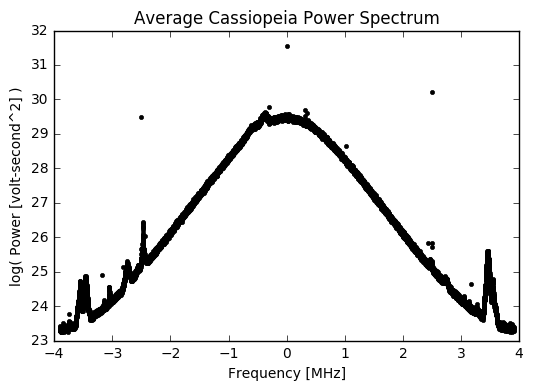

In [40]:
data = np.load('cassie.npy')

P_cassie = avg_ps(data, 1000)
freq = np.fft.fftfreq(len(P_cassie), 1/(62.5/8))
plt.plot(freq, np.log(P_cassie), 'k.')
plt.title('Average Cassiopeia Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('log( Power [volt-second^2] )')
plt.show()

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_upper', x)

Upper LO = 191 MHz

x = ugradio.pico.capture_data('50mV', divisor=8, dual_mode=True, nsamples=16000, nblocks=1000, host='10.32.92.95', port=1340, verbose=False)

np.save('cassie_lower', x)

Lower LO = 189 MHz

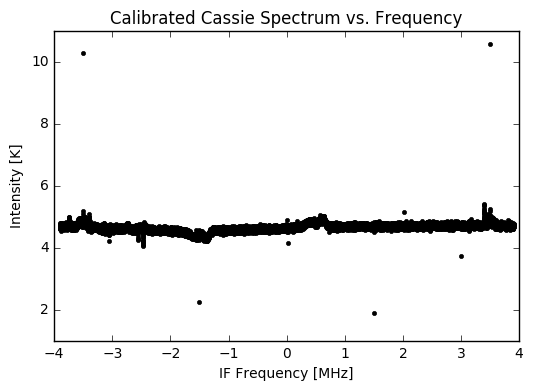

In [52]:
upper_data = np.load('cassie_upper.npy')
lower_data = np.load('cassie_lower.npy')

P_upper = avg_ps(upper_data, 1000)
P_lower = avg_ps(lower_data, 1000)

s_line_cassie = P_upper/P_lower
T_line_cassie = s_line_cassie * G

f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))

plt.plot(f, np.log(T_line_cassie), 'k.')
plt.title('Calibrated Cassie Spectrum vs. Frequency')
plt.xlabel('IF Frequency [MHz]')
plt.ylabel('Intensity [K]')
plt.show()

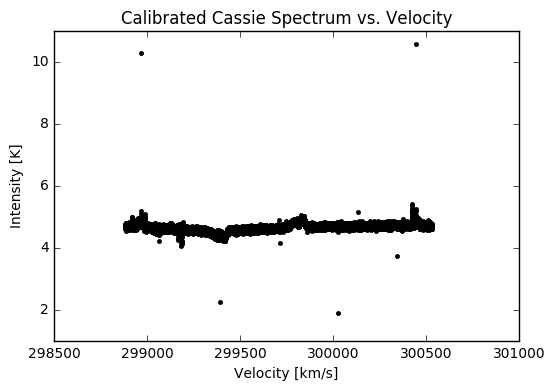

In [54]:
f = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8)) + 1420

c = 299792.458 #km/s
f_0 = 1420.4058 # MHz
velocity = c * frequency/f_0

plt.plot(velocity, np.log(T_line_cassie), 'k.')
plt.title('Calibrated Cassie Spectrum vs. Velocity')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.locator_params(axis='x', nbins=8)
plt.show()

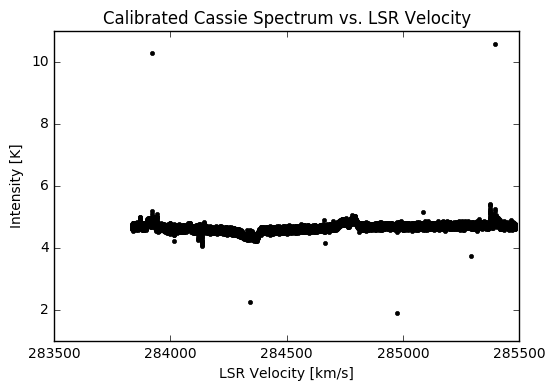

In [73]:
v = -15047.90968951

plt.plot(velocity + v, np.log(T_line_cassie), 'k.')
plt.title('Calibrated Cassie Spectrum vs. LSR Velocity')
plt.xlabel('LSR Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.locator_params(axis='x', nbins=8)
plt.show()

<IPython.core.display.Javascript object>


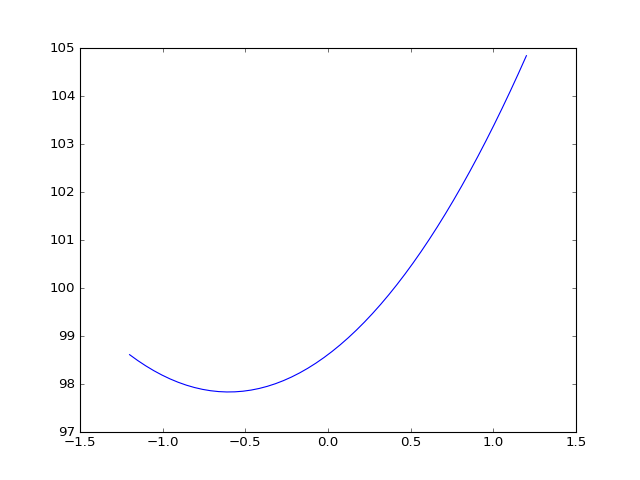

In [132]:
freq = np.fft.fftfreq(len(T_line_cassie), 1/(62.5/8))

poly = np.polyfit(freq, T_line_cassie, 2)

x = np.linspace(-1.2, 1.2)
y = poly[0]*x**2 + poly[1]*x + poly[2]
plt.plot(x, y)

In [106]:
def smooth(data):
    """Reduces noise in a spectrum by averaging over 3 channels. Slightly degrades spectral resolution.
    
    Parameters
    ----------
    data : power spectrum
    
    Returns
    -------
    smooth : smoothed power spectrum"""
    
    n = 1

    smooth = [data[0]]

    for i in range(n, len(data)):
        if i < len(data):
            span = data[i-n:i+n]
            smooth_value = np.mean(span)
            smooth.append(smooth_value)
        else:
            smooth.append(data[len(data)])
    return smooth

<IPython.core.display.Javascript object>


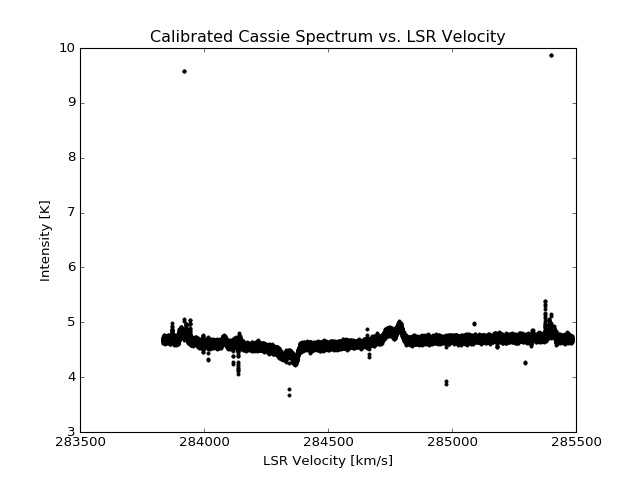

In [130]:
v = -15047.90968951

plt.plot(velocity + v, np.log(smooth(T_line_cassie)), 'k.')
plt.title('Calibrated Cassie Spectrum vs. LSR Velocity')
plt.xlabel('LSR Velocity [km/s]')
plt.ylabel('Intensity [K]')
plt.locator_params(axis='x', nbins=8)
plt.show()

In [122]:
import ugradio.gauss as gs

def gaussfit(x, y, amp=1., avg=0., sig=1., return_cov=False):
    '''Fit amp, avg, and sig for a Gaussian [y = amp * e^(-(x-avg)^2/(2*sig^2)].
    amp/avg/sig can be lists/arrays to simultaneously fit multiple Gaussians.
    Parameters
    ----------
    x : x coordinate at which Gaussian is evaluated
    y : measured y coordinate to which Gaussian is compared
    amp : first guess at amp, the amplitude(s) of the Gaussian(s), default=1.
    avg : first guess at avg, the average(s) of the Gaussian(s), default=0.
    sig : first guess at sig, the width(s) of the Gaussian(s), default=1.
    return_cov : return the [amp, avg, sig] covariance matrix of the solution

    Returns
    -------
    ans : dictionary with amp/avg/sig keys and fit solutions as values.
    prm_covariance : the [amp, avg, sig] covariance matrix'''
    prms0 = _pack_prms(amp, avg, sig)
    prms, prm_covariance = curve_fit(_gauss, x, y, p0=prms0)
    amp, avg, sig = _unpack_prms(prms)
    ans = {'amp':amp.flatten(), 'avg':avg.flatten(), 'sig':sig.flatten()}
    if return_cov:
        return ans, prm_covariance
    else:
        return ans

In [129]:
gauss = gs.gaussfit(0, 4.65, 0.3, 0, 50)
print(gauss)

TypeError: Improper input: N=3 must not exceed M=1